# Introduction

This project seeks to solve the problem of identifying pathological images as cancerous or non-cancerous. Better classification tools could help doctors detect cancer earlier and save patients' lives. 

The data for this competition is a version of the PatchCamelyon (PCam) benchmark dataset that does not contain duplicates. I obtained the dataset from the Kaggle competition page[3]. The data was provided to Kaggle by Bas Veeling[1], with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak[2].

The data consists of 96x96 color images extracted from histopathologic scans of lymph node sections. Each image is labelled to reflect the presence of metastatic tissue (cancer). There are 220,025 images in the training dataset

In [2]:
# Important Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# EDA and Data Cleaning
from PIL import Image

# Model Building and Training
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import Callback, EarlyStopping

# Fully Connected NN


In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploratory Data Analysis

To learn more about the dataset I will display a few examples of images of lymph node sections. I will also compare the relative frequency of cancerous and non-cancerous images. 

Each image can be represented by a 96x96x3 matrix of numerical values representing the pixels of the image and values for red, blue, and green. Therefore our dataset has 220,025 observations each with 27648 numerical features.

Image shape: (96, 96, 3)


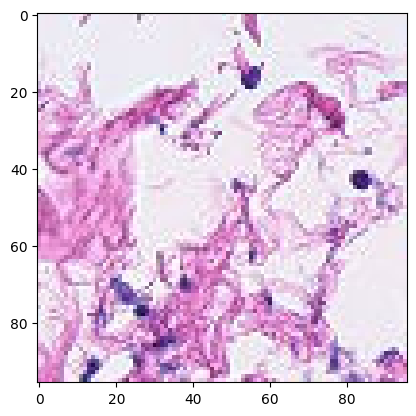

In [4]:
# Function to load images
def train_img_path(id_str):
    return os.path.join(r'train', f'{id_str}.tif')

# Load an example training image
example_img_path = train_img_path('0000d563d5cfafc4e68acb7c9829258a298d9b6a')
example_img = Image.open(example_img_path)
example_array = np.array(example_img)

print(f'Image shape: {example_array.shape}')
plt.imshow(example_img)
plt.show()


In [5]:
train_labels_df = pd.read_csv('train_labels.csv')

# add column of file paths, id corresponds to file name
train_labels_df['filename'] = train_labels_df['id'].apply(train_img_path)

# convert label to string
train_labels_df['label'] = train_labels_df['label'].astype(str)
print(train_labels_df['filename'].iloc[0])

try:
    img = Image.open(train_labels_df['filename'].iloc[0])
    img.show()  # This will display the image if it opens successfully
except Exception as e:
    print(f"Error opening image: {e}")

train\f38a6374c348f90b587e046aac6079959adf3835.tif


In [7]:
train_labels_df.shape

(220025, 3)

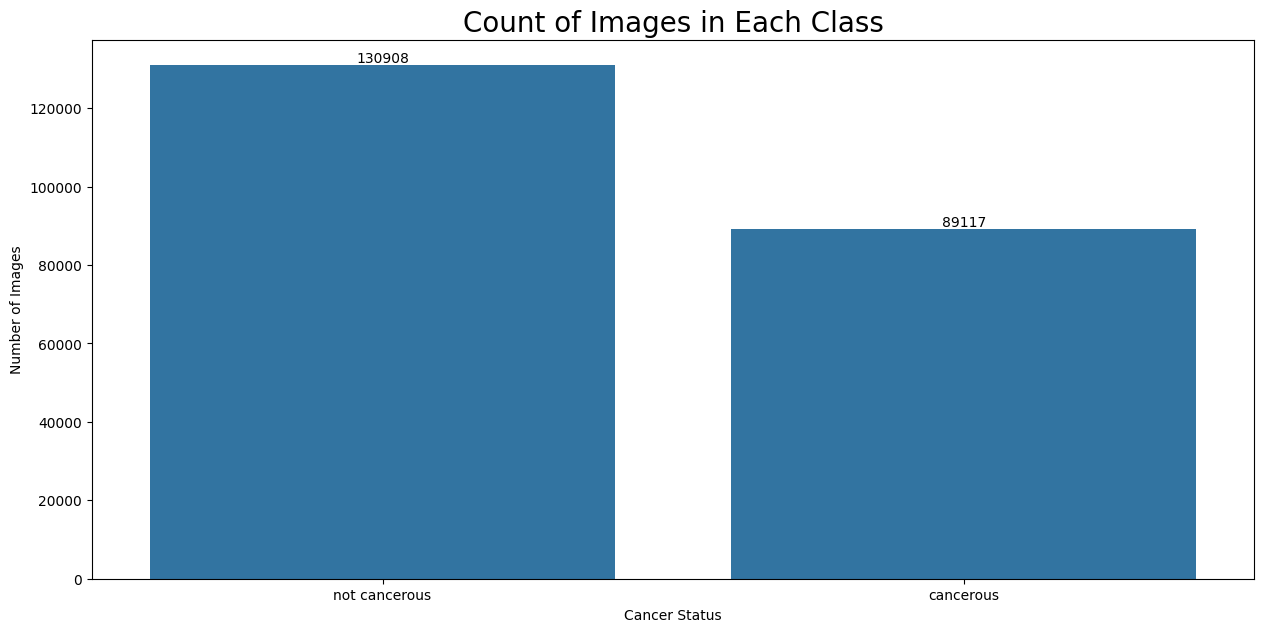

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_labels_df , x=train_labels_df['label'])

plt.xlabel('Cancer Status')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0,1], labels=['not cancerous', 'cancerous'])
plt.title('Count of Images in Each Class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

There is a discrepancy between the number of cancerous and non-cancerous images in the dataset. Since there are more images labeled as non-cancerous the model could become biased towards this label. Balancing the classes could remedy this issue. The imbalance also means metrics like accuracy will not properly reflect the quality of the predictions. The Kaggle competition uses ROC-AUC as its metric to determine the leaderboard which is less influenced by imbalanced classes.

In [9]:
# Load the first 100 images
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(100):
    img_path = train_labels_df['filename'][i]
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

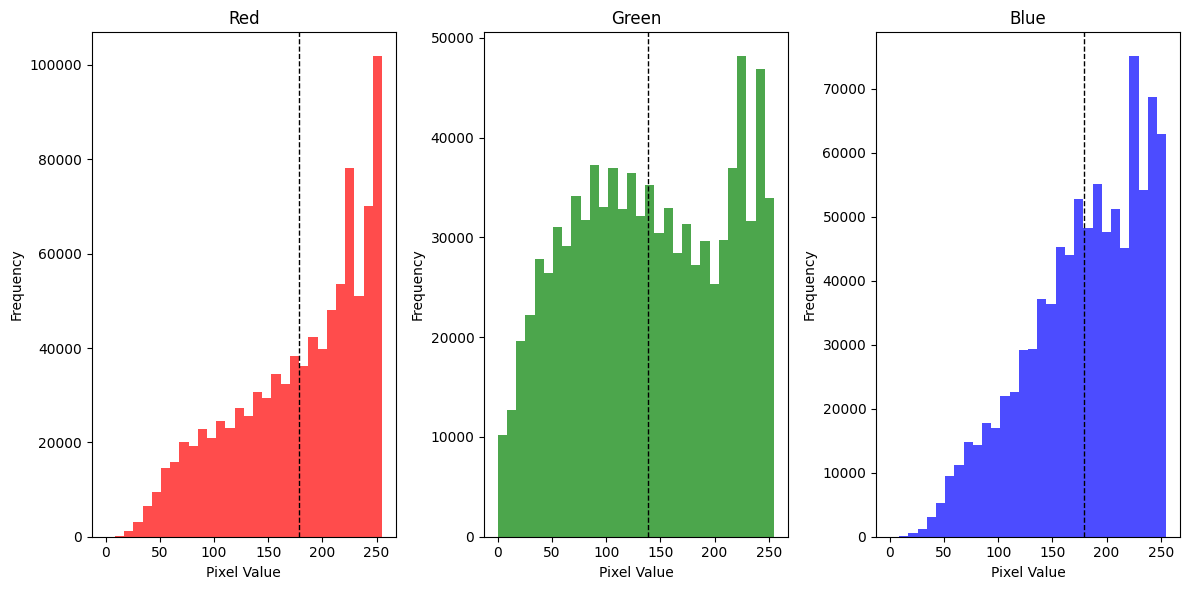

In [10]:
# Calculate the mean for each 96x96 observation across the first dimension (observations)
mean_values = np.mean(sample_data, axis=0)  # Shape will be (96, 96, 3)

# Now, calculate the mean across the spatial dimensions (height and width) for each channel
mean_channel_values = np.mean(mean_values, axis=(0, 1))  # Shape will be (3,)

# Create histograms for each channel
colors = ['r', 'g', 'b']  # Assuming channels are in RGB order
channel_labels = ['Red', 'Green', 'Blue']

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(sample_data[..., i].flatten(), bins=30, color=colors[i], alpha=0.7)
    plt.axvline(mean_channel_values[i], color='k', linestyle='dashed', linewidth=1)
    plt.title(channel_labels[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As can be seen from the pixel value histograms red and blue have much higher average pixel values than green. This can be seen in the example images which are predominantly purple. All of the pixel value histograms have some values near 255 likely corresponding to black parts of the image.

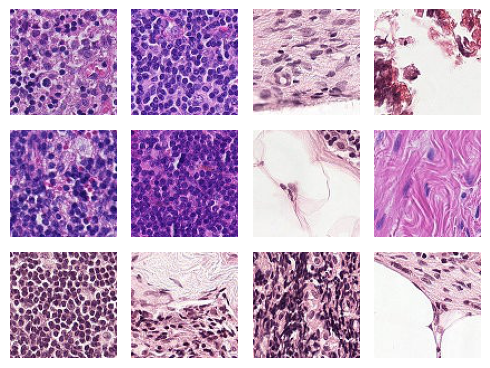

In [11]:
# Get 12 random non-cancerous images
sample_non_cancerous = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = 4

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][sample_non_cancerous[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

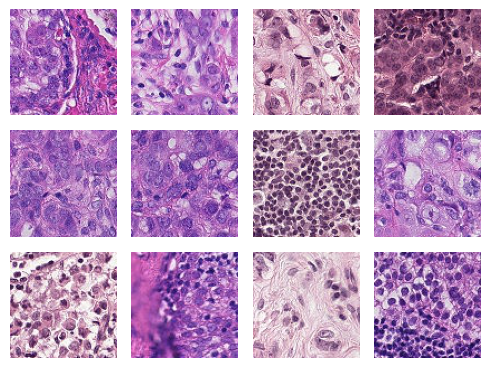

In [12]:
# Get 12 random cancerous images
sample_cancerous = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = 4

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][sample_cancerous[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing
This data came from a Kaggle competition so most of the data cleaning was already completed. There are no missing values so nothing needs to be imputed. All of the data is in image form with numerical values for the individual pixels in each color. This means there is no need to one-hot encode categorical data. Keras has an ImageDataGenerator class which I will use to preprocess the data. To use the class_mode binary I needed to convert my labels to strings. I will normalize the images to [0,1] range using the rescale parameter because different scales can easily be amplified through a neural network and have an outsized effect on the model. I set aside 20% of the training data for validation during the fitting process.

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = True,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = True,
    seed = 10
)

# small portion of data used to tune hyperparameters
smaller_train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels_df.sample(frac=0.1),
    shuffle = True,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = True,
    seed = 10
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 17602 validated image filenames belonging to 2 classes.


# Model Building and Training

For my model I took inspiration from the VGGnet model which performs well at classifying images. This model consists of a separate feature extractor section and classifier section. The feature extractor section has convolution layers and max pool layers. Convolution layers are able to detect features in the dataset with much fewer parameters than a fully connected layer. The fewer parameters leads to computational efficiency and better classifying performance. The max pool layers increase the field of reference for the pixels in later layers which captures more complex interactions between features. 

Max pooling also decreases the size of the feature map. Because of this decrease in input size I was able to increase the number of filters for the later stages of my model.

VGG16 uses three fully connected layers as the classifier section. Due to computational resource constraints on my machine I will use one fully connected layer instead. I used a sigmoid activation function for the output layer to match the problem type of binary classification.

VGG16 is available for import from tensorflow. While it would be possible to use transfer learning to use the first few layers from the pre-trained VGG16, I will build my own model to set my own parameters. I will follow the structure of the A configuration for VGG16, the simplest configuration.

I will start by tuning the learning rate hyperparameter using a small subset of the data.

In [60]:
class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-1, steps=100):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        self.best_loss = (float('inf'), -1)

    def on_batch_end(self, batch, logs=None):
        # Compute learning rate for this batch
        lr = self.min_lr * (self.max_lr / self.min_lr) ** (batch / self.steps)
        if lr > self.max_lr:
            self.model.stop_training = True
        self.model.optimizer.lr = lr
        self.lrs.append(lr)
        
        # Log the loss
        loss = logs.get('loss')
        if loss is not None:
            self.losses.append(loss)
            # Stop if loss explodes
            if loss > 4 * self.best_loss[0]:
                self.model.stop_training = True
            elif loss < self.best_loss[0]:
                
                self.best_loss = (loss, lr)

In [61]:
# Architecture of short training session
# Fewer filters and layers to speed up process
t_input = Input((96, 96, 3))

# Stage 1
t_conv1  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(t_input)
t_pool1  = MaxPooling2D((2, 2))(t_conv1)

# Stage 2
t_conv2  = Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(t_pool1)
t_pool2  = MaxPooling2D((2, 2))(t_conv2)

# Stage 3
t_conv3  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(t_pool2)
t_pool3  = MaxPooling2D((2, 2))(t_conv3)

# Stage 4
t_conv5  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(t_pool3)
t_pool4  = MaxPooling2D((2, 2))(t_conv5)

# Stage 5
t_conv7 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(t_pool4)
t_pool5  = MaxPooling2D((2, 2))(t_conv7)

# Classifier stage
flat   = Flatten()(t_pool5)
t_output = Dense(1, activation="sigmoid")(flat)

t_model  = Model(inputs=t_input, outputs=t_output)

In [62]:
# Smaller dataset and fewer epochs for training
t_model.compile(optimizer = Nadam(),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC()])

lr_finder = LearningRateFinder(min_lr=1e-7, max_lr=0.05, steps=100)

t_history = t_model.fit(
    smaller_train_generator,
    epochs=1,
    callbacks=[lr_finder]
)

551/551 [==============================] - 6s 9ms/step - loss: 1.3042 - accuracy: 0.5870 - auc_9: 0.5292


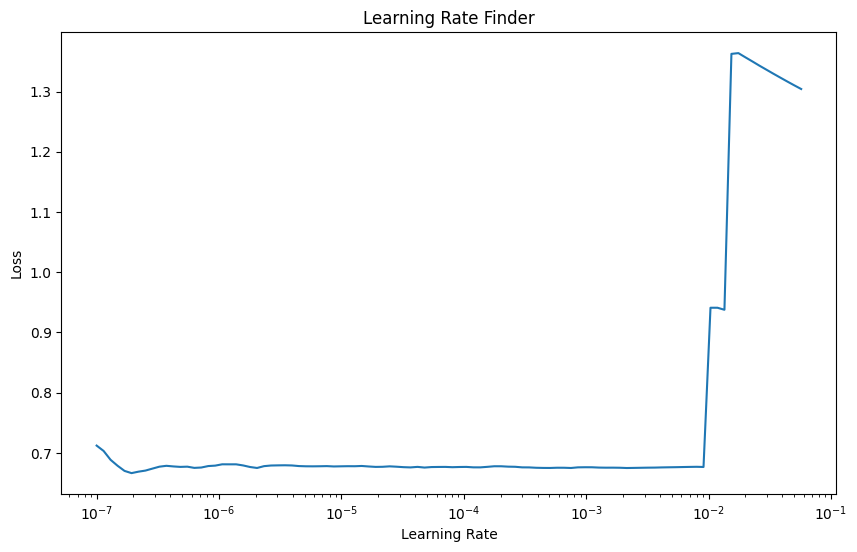

Learning rate with the lowest loss: 1.9272963557631286e-07


In [70]:
# Loss explodes after learning rate of 0.1 rendering the plot meaningless, filter those values out
lrs = np.array(lr_finder.lrs)
losses = np.array(lr_finder.losses)
lr_threshold = 0.01
mask = lrs < lr_threshold
filterd_lrs = lrs[mask]
filtered_losses = losses[mask]

plt.figure(figsize=(10, 6))
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xlabel('Learning Rate')
plt.xscale('log')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()
print(f'Learning rate with the lowest loss: {lr_finder.best_loss[1]}')

In [7]:
# CNN Model Architecture
_input = Input((96,96,3))

# Stage 1
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
pool1  = MaxPooling2D((2, 2))(conv1)

# Stage 2
conv2  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
pool2  = MaxPooling2D((2, 2))(conv2)

# Stage 3
conv3  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv4  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool3  = MaxPooling2D((2, 2))(conv4)

# Stage 4
conv5  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv6  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv5)
pool4  = MaxPooling2D((2, 2))(conv6)

# Stage 5
conv7 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv8 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv7)
pool5  = MaxPooling2D((2, 2))(conv8)

# Classifier stage
flat   = Flatten()(pool5)
output = Dense(1, activation="sigmoid")(flat)

model  = Model(inputs=_input, outputs=output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       295168

In [8]:
model.compile(optimizer = Nadam(learning_rate = 0.00001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC()])

The model was optimized by using the Nadam optimizer. Nadam is Adam with Nesterov momentum. This optimizer squashes the learning rate based on the current loss gradient. It also uses momentum to help the model escape local minima in the loss gradient. Binary cross entropy was used as the loss function to match the goal of binary classification of lymph node images.

Regularization was done through early stopping. 

In [9]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 15,
    callbacks=[early_stop_callback]
)

Epoch 1/15
5501/5501 [==============================] - 1106s 200ms/step - loss: 0.4482 - accuracy: 0.7938 - auc: 0.8653 - val_loss: 0.3932 - val_accuracy: 0.8261 - val_auc: 0.8965
Epoch 2/15
5501/5501 [==============================] - 766s 139ms/step - loss: 0.3675 - accuracy: 0.8380 - auc: 0.9119 - val_loss: 0.3344 - val_accuracy: 0.8556 - val_auc: 0.9310
Epoch 3/15
5501/5501 [==============================] - 224s 41ms/step - loss: 0.3273 - accuracy: 0.8580 - auc: 0.9308 - val_loss: 0.3268 - val_accuracy: 0.8556 - val_auc: 0.9381
Epoch 4/15
5501/5501 [==============================] - 204s 37ms/step - loss: 0.3047 - accuracy: 0.8706 - auc: 0.9403 - val_loss: 0.2945 - val_accuracy: 0.8748 - val_auc: 0.9481
Epoch 5/15
5501/5501 [==============================] - 205s 37ms/step - loss: 0.2837 - accuracy: 0.8807 - auc: 0.9483 - val_loss: 0.2724 - val_accuracy: 0.8877 - val_auc: 0.9541
Epoch 6/15
5501/5501 [==============================] - 206s 37ms/step - loss: 0.2621 - accuracy: 0.89

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


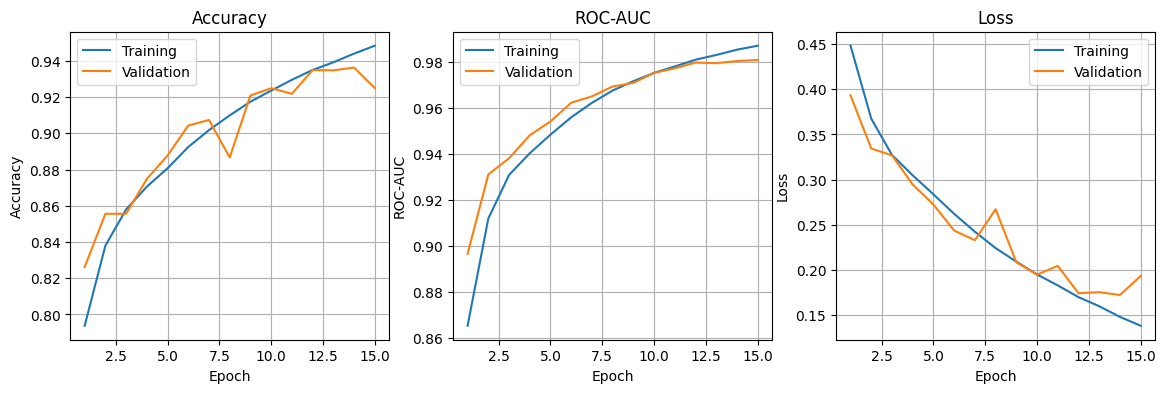

In [11]:
h = history.history
print(h.keys())
epoch_range = range(1, len(h['loss'])+1)

plt.figure(figsize=[14,4])
n = int(len(h.keys()) / 2)

# Plot accuracy
plt.subplot(1,3,1)
plt.plot(epoch_range, h['accuracy'], label='Training')
plt.plot(epoch_range, h['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.grid()
plt.legend()

# Plot ROC-AUC
plt.subplot(1,3,2)
plt.plot(epoch_range, h['auc'], label='Training')
plt.plot(epoch_range, h['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('ROC-AUC'); plt.title('ROC-AUC')
plt.grid()
plt.legend()

# Plot Loss
plt.subplot(1,3,3)
plt.plot(epoch_range, h['loss'], label='Training')
plt.plot(epoch_range, h['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.grid()
plt.legend()


In [23]:
print(h['val_auc'])

[0.8965280652046204, 0.9310410022735596, 0.9380616545677185, 0.9480567574501038, 0.9540772438049316, 0.9622068405151367, 0.9649541974067688, 0.9692668914794922, 0.9708271026611328, 0.9751484990119934, 0.9771556258201599, 0.9796777963638306, 0.9793816208839417, 0.9803325533866882, 0.9807847738265991]


In [13]:
# Create dataframe of filenames corresponding to the test data, no labels for test data
test_path = 'test'
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [20]:
# Create predictions of the test data to submit to Kaggle competition
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = True,
    seed = 10
)

predictions = model.predict(test_generator)

Found 57458 validated image filenames.
898/898 [==============================] - 296s 330ms/step


In [22]:
# Convert numpy array of predictions to format specified by sample submission

predicted_labels = (predictions > 0.5).astype(int)
test_df['label'] = predicted_labels
submission_df = test_df.drop(['filename'], axis=1)
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0


# Results and Analysis

The CNN model takes about 2 hours to train on a NVIDIA GeForce 2070 Super with 15 epochs. The training time could be improved by setting GPU memory growth at program startup, using a more powerful GPU, or using a GPU server. 

The model achieved an ROC-AUC of 0.987 on the validation data and 0.8810 on the test data. This discrepancy could be due to differences between the datasets or overfitting of the model.

The most significant hyperparameter that can be tuned is learning rate. Too high of a learning rate and the parameters change too significantly with each iteration to ever find the optimal values. Too low of a learning rate and the model may never reach the optimal parameters during training or get stuck in a local gradient minimum. Initially, I used 1e-4 as the learning rate which resulted in peak performance of the model after 5 epochs with and ROC-AUC of 0.987. Hyperparameter tuning of the learning rate using a LearningRateFinder callback on a smaller dataset, fewer filters, and fewer layers recommended a learning rate of 1.9e-7. Using the lower rate slowed down the training of the model significantly, resulting in lower accuracy that 1e-4 after 10 epochs. The graph of loss versus learning rate showed good performance up until 1e-4 learning rate so I chose a value of 1e-5 to balance speed of training with model performance. I also changed the training time from 10 epochs to 15 epochs to ensure the model found the optimal parameters during training. The best validation loss was at 12 epochs and the preformance on the validation data worsened after that. To improve the final model I could improve my LearningRateFinder callback by monitoring validation loss instead of training loss as the metric to determine the best learning rate. 

Overfitting is a concern as neural networks learn more about the training data. While training loss typically decreases throughout the training process, validation loss can reach a minimum then increase signifying overfitting. To protect against overfitting I used an early stopping callback. This callback uses a copy of the model to save the best parameters during the training process, even if those parameters occur earlier in the process. The callback also stops the training process if validation loss does not improve for five epochs in a row. 

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Comparison with Fully Connected Neural Network
model_nn = Sequential([
    Flatten(input_shape=(96, 96, 3)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nn.compile(optimizer=Nadam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC()])

# Train the model
# Train the model
history_nn = model_nn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Evaluate the model
eval_result_mlp = model_nn.evaluate(validation_generator)
print(f"MLP Model - Loss: {eval_result_mlp[0]}, Accuracy: {eval_result_mlp[1]}")

Epoch 1/10
5501/5501 [==============================] - 809s 147ms/step - loss: 0.6300 - accuracy: 0.6115 - auc_2: 0.6581 - val_loss: 0.6161 - val_accuracy: 0.6215 - val_auc_2: 0.7050
Epoch 2/10
5501/5501 [==============================] - 832s 151ms/step - loss: 0.6052 - accuracy: 0.6509 - auc_2: 0.7130 - val_loss: 0.5885 - val_accuracy: 0.6684 - val_auc_2: 0.7353
Epoch 3/10
5501/5501 [==============================] - 400s 73ms/step - loss: 0.5852 - accuracy: 0.6691 - auc_2: 0.7341 - val_loss: 0.5821 - val_accuracy: 0.6858 - val_auc_2: 0.7448
Epoch 4/10
5501/5501 [==============================] - 158s 29ms/step - loss: 0.5727 - accuracy: 0.6953 - auc_2: 0.7542 - val_loss: 0.5677 - val_accuracy: 0.7218 - val_auc_2: 0.7668
Epoch 5/10
5501/5501 [==============================] - 152s 28ms/step - loss: 0.5570 - accuracy: 0.7216 - auc_2: 0.7781 - val_loss: 0.5644 - val_accuracy: 0.7153 - val_auc_2: 0.7756
Epoch 6/10
5501/5501 [==============================] - 146s 27ms/step - loss: 0.54

# Conclusion and Discussion

The CNN model performed well at classifying lymph node images as either cancerous or non-cancerous. The best ROC-AUC on the validation data was 0.987 which is significantly better than the 0.790 obtained using the fully connected neural network. These results are expected because CNN is designed to take grid-shaped inputs like images.

The model could be improved through regularization. I used early stopping as my main regularization method. While the inputs were normalized before feeding them to the first convolution layer, batch normalization after each layer could further improve performance. Other regularization methods such as L2 regularization or dropouts could also be implemented. Regularization could mitigate the effects of overfitting.

I could also balance the classes, cancerous and non-cancerous. The model may have been biased towards the non-cancerous class because it occured with higher frequency.

The model could also be improved by more learning rate tuning. My initial learning rate of 1e-4 had the best ROC-AUC for the validation data of 0.987. My learning rate finder callback found 1.9e-7 to be the best learning rate but neither that rate nor 1e-5 were able to beat the ROC-AUC of 0.987 within the training time. With more compute and more time to dedicate to training the model these slower learning rates could perform better.

## Citations

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

[3] https://www.kaggle.com/c/histopathologic-cancer-detection/overview

[4] https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

[5] https://www.kaggle.com/code/mohammedhamzamoawad/histopathologic-cancer-detection

[6] https://keras.io/api/optimizers/Nadam/